In [651]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from math import sqrt
from sklearn.metrics import mean_squared_error 
import numpy as np
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.cluster import AgglomerativeClustering 
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance import pdist
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import matplotlib as mat
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score


In [652]:
df=pd.read_csv("cars-dataset.csv",na_values=["?","$","%","#"])

In [653]:
df.head()

,car name,cyl,disp,hp,wt,acc,yr,mpg
0,chevrolet chevelle malibu,8,307.0,130.0,3504,12.0,70,18.0
1,buick skylark 320,8,350.0,165.0,3693,11.5,70,15.0
2,plymouth satellite,8,318.0,150.0,3436,11.0,70,18.0
3,amc rebel sst,8,304.0,150.0,3433,12.0,70,16.0
4,ford torino,8,302.0,140.0,3449,10.5,70,17.0


###### Point 1: EDA and Pre-Processing

In [654]:
df.columns

Index(['car name', 'cyl', 'disp', 'hp', 'wt', 'acc', 'yr', 'mpg'], dtype='object')

In [655]:
df.shape

(398, 8)

In [656]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
cyl,398.0,5.454774,1.701004,3.0,4.000,4.0,8.000,8.0
disp,398.0,193.425879,104.269838,68.0,104.250,148.5,262.000,455.0
hp,392.0,104.469388,38.491160,46.0,75.000,93.5,126.000,230.0
wt,398.0,2970.424623,846.841774,1613.0,2223.750,2803.5,3608.000,5140.0
acc,398.0,15.568090,2.757689,8.0,13.825,15.5,17.175,24.8
yr,398.0,76.010050,3.697627,70.0,73.000,76.0,79.000,82.0
mpg,398.0,23.514573,7.815984,9.0,17.500,23.0,29.000,46.6


In [657]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
car name    398 non-null object
cyl         398 non-null int64
disp        398 non-null float64
hp          392 non-null float64
wt          398 non-null int64
acc         398 non-null float64
yr          398 non-null int64
mpg         398 non-null float64
dtypes: float64(4), int64(3), object(1)
memory usage: 25.0+ KB


In [658]:
#Checking for null values in various columns
df.isnull().any()

car name    False
cyl         False
disp        False
hp           True
wt          False
acc         False
yr          False
mpg         False
dtype: bool

###### Decision:
    1. KNN Regressor will be used to impute Null Values for HP column
    2. KNN Regressor will work efficiently if attribute having missing values is strongly 
       related to other attributes in the dataset.
       So before proceeding with KNN to impute Null Values, correlation of HP will be checked 
       with other columns
   

In [659]:
#Checking the correation of HP column with other attributes
for col in df.columns:
    if col in ["car name","hp"]:  
        continue
    else:
        print("Correlation of HP with",col,":\n",df[["hp",col]].corr(method="pearson"))
        print("\n")

Correlation of HP with cyl :
            hp       cyl
hp   1.000000  0.842983
cyl  0.842983  1.000000


Correlation of HP with disp :
             hp      disp
hp    1.000000  0.897257
disp  0.897257  1.000000


Correlation of HP with wt :
           hp        wt
hp  1.000000  0.864538
wt  0.864538  1.000000


Correlation of HP with acc :
            hp       acc
hp   1.000000 -0.689196
acc -0.689196  1.000000


Correlation of HP with yr :
           hp        yr
hp  1.000000 -0.416361
yr -0.416361  1.000000


Correlation of HP with mpg :
            hp       mpg
hp   1.000000 -0.778427
mpg -0.778427  1.000000




###### Observation:

Because correlation of HP column with rest of the columns in the dataset is high, we can proceed 

with standardizing the data to use KNN to imput the Missing Values

In [660]:
scaler=StandardScaler()

In [661]:
features=["cyl","disp","wt","acc","yr","mpg"]
target=["hp"]

In [662]:
#Samples for which missing value of HP will be imputed
missing_samples=df[df["hp"].isnull()][features]
scaled_values=scaler.fit_transform(missing_samples)
missing_samples=pd.DataFrame(scaled_values,columns=features)


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [663]:
#Samples that will be used for KNN Training
df_imputing=df[df["hp"].notnull()]
df_imputing=df_imputing.drop(["car name"],axis=1)
scaled_values=scaler.fit_transform(df_imputing)
df_imputing=pd.DataFrame(scaled_values,
                         columns=['cyl', 'disp', 'hp', 'wt', 'acc','yr','mpg'])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [664]:
X=df_imputing[features]
y=df_imputing[target]

In [665]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.30)

In [666]:
rmse=[]
for k in range(1,26):
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train,y_train)
    y_predicted=model.predict(X_test)
    error = sqrt(mean_squared_error(y_test,y_predicted)) 
    rmse.append(error)
    print("For k:",k,"  RMSE is:",error)

For k: 1   RMSE is: 0.27264994404821563
For k: 2   RMSE is: 0.27394564905358054
For k: 3   RMSE is: 0.29811742889617426
For k: 4   RMSE is: 0.30111138150955064
For k: 5   RMSE is: 0.3121164224482984
For k: 6   RMSE is: 0.3233750646589698
For k: 7   RMSE is: 0.3352145018338575
For k: 8   RMSE is: 0.33765230367051713
For k: 9   RMSE is: 0.34207842315130343
For k: 10   RMSE is: 0.34133912947235423
For k: 11   RMSE is: 0.3375481169002962
For k: 12   RMSE is: 0.34015275965538083
For k: 13   RMSE is: 0.3414742285297632
For k: 14   RMSE is: 0.3382538164334053
For k: 15   RMSE is: 0.34051452256723724
For k: 16   RMSE is: 0.34497895710137716
For k: 17   RMSE is: 0.34726813004851115
For k: 18   RMSE is: 0.34771388680273035
For k: 19   RMSE is: 0.35170492508815804
For k: 20   RMSE is: 0.35516679486111524
For k: 21   RMSE is: 0.3579063610224598
For k: 22   RMSE is: 0.3599478663403411
For k: 23   RMSE is: 0.36291042463568274
For k: 24   RMSE is: 0.36667983960674233
For k: 25   RMSE is: 0.3663520678

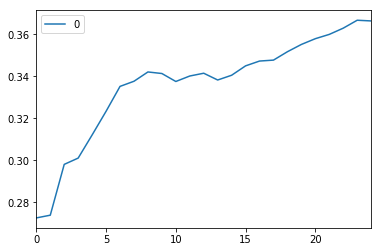

In [667]:
curve = pd.DataFrame(rmse) #elbow curve 
curve.plot()

In [668]:
#Looks like k=6 will be a better option to impute the missing values
model = KNeighborsRegressor(n_neighbors=6)
model.fit(X_train,y_train)
y_predicted=model.predict(X_test)
error = sqrt(mean_squared_error(y_test,y_predicted)) 
print(error)


0.3233750646589698


In [669]:
missing_samples

,cyl,disp,wt,acc,yr,mpg
0,-0.447214,-0.783869,-0.991983,0.833573,-1.732051,-0.416680
1,2.236068,1.795312,0.808792,-0.156811,-0.989743,-0.972253
2,-0.447214,-1.112588,-1.450323,-0.008253,0.494872,1.791724
3,-0.447214,0.278147,0.873959,-1.493829,0.494872,-0.611131
4,-0.447214,-0.733297,-0.396793,-0.751041,0.742307,0.902807
5,-0.447214,0.556294,1.156348,1.576361,0.989743,-0.694467


In [670]:
#Use k as 6 to impute missing values
predict=model.predict(missing_samples)

In [671]:
missing_samples["hp"]=model.predict(missing_samples)

In [672]:
df_imputing.columns=missing_samples.columns

In [673]:
cars_df=pd.concat([df_imputing,missing_samples],axis=0)


In [674]:
cars_df.isnull().any()

cyl     False
disp    False
wt      False
acc     False
yr      False
mpg     False
hp      False
dtype: bool

In [675]:
len(cars_df)

398

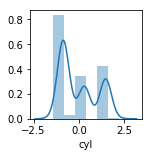

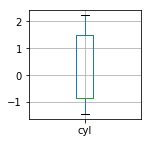

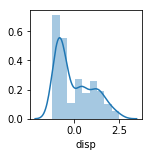

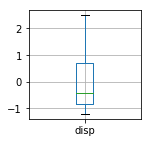

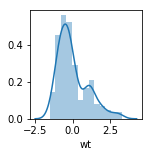

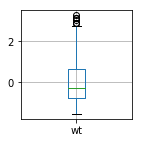

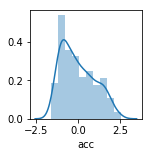

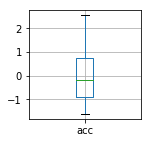

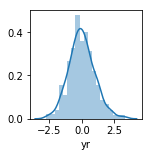

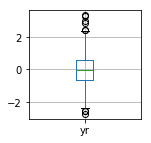

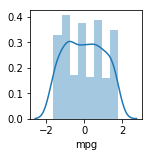

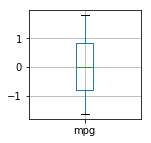

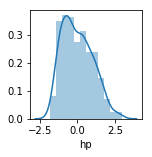

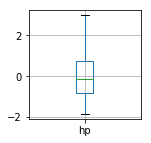

In [676]:
# Check for the presence of outliers
for col in cars_df.columns:
    plt.figure(figsize=(2,2))
    sns.distplot(cars_df[col])
    plt.figure(figsize=(2,2))
    cars_df.boxplot([col])

In [677]:
#Removing the outliers
cars_df=cars_df[(np.abs(cars_df)<3).all(axis=1)]

In [678]:
cars_df.columns

Index(['cyl', 'disp', 'wt', 'acc', 'yr', 'mpg', 'hp'], dtype='object')

In [679]:
# After Removing the outliers, length of cars_df is:
len(cars_df)

391

Point 2: Using Pair Plot to check the possible number of clusters

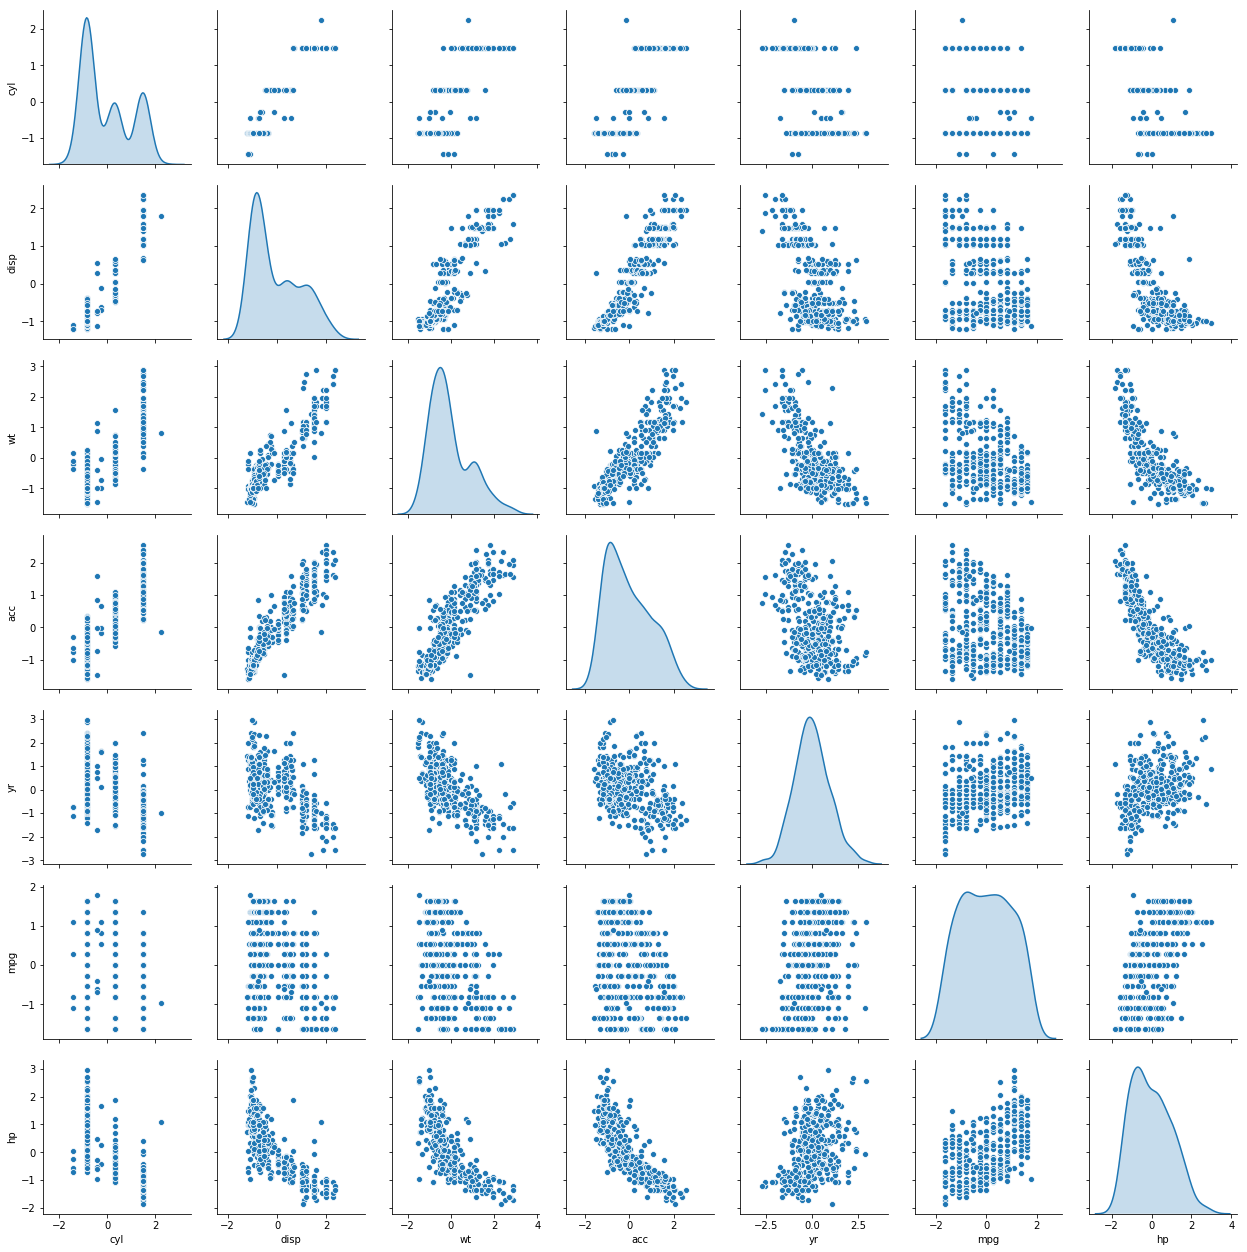

In [680]:
#Checking the possible number of clustersa
sns.pairplot(cars_df, diag_kind='kde') 

###### Observation:
From pairplot, it looks like we have 2-3 clusters

Point 3.a: Using K-Means Clustering to find the clusters

In [681]:
cluster_range = range(2,5)   
cluster_errors = []
for number_of_clusters in cluster_range:
    clusters = KMeans(number_of_clusters,n_init = 5)
    clusters.fit(cars_df)
    labels = clusters.labels_
    centroids = clusters.cluster_centers_
    cluster_errors.append(clusters.inertia_)
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "variance_within_clusters": cluster_errors } )
clusters_df

,num_clusters,variance_within_clusters
0,2,1239.623537
1,3,908.358356
2,4,707.981516


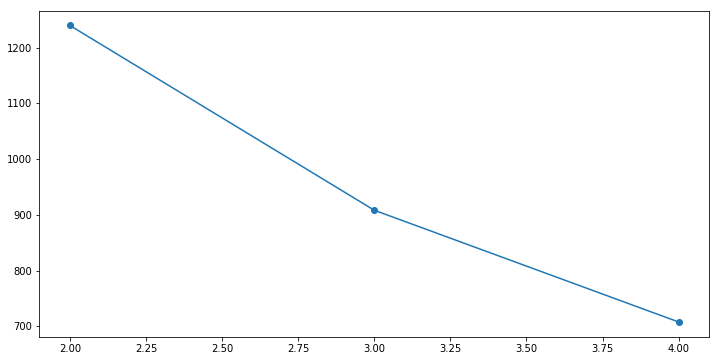

In [682]:
# Elbow plot
plt.figure(figsize=(12,6))
plt.plot(clusters_df.num_clusters, clusters_df.variance_within_clusters, marker = "o")

Observation: 
    From Elbow Plot as well, we decided to consider 3 clusters

In [683]:
# Finally using KMeans to create 3 clusters
clusters = KMeans(n_clusters=3,n_init = 5)
clusters.fit(cars_df)
KMeans_labels = clusters.labels_
KMeans_centroids = clusters.cluster_centers_
KMeans_errors=clusters.inertia_

In [684]:
KMeans_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2,
       1, 1, 1, 1, 0, 0, 0, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 0, 2,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 2, 0, 2, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 2, 2, 2, 2, 0, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 2, 0,
       1, 0, 0, 0, 2, 1, 0, 2, 1, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 1, 1, 1, 1, 2,
       2, 2, 2, 2, 2, 1, 0, 0, 2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 0, 0, 0, 0, 2, 2, 2, 2, 0, 0,
       0, 0, 2, 1, 2, 2, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 2, 1, 1, 2, 2,
       2, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
       2, 1, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 2, 0, 2, 0, 0, 2, 2, 0, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1,
       0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0,

In [685]:
KMeans_centroids

array([[-0.84349713, -0.80239447, -0.66432556, -0.79733738,  0.31394577,
         0.31813403,  0.74656223],
       [ 1.49212225,  1.4356936 ,  1.39379176,  1.36244999, -1.00077418,
        -0.61960901, -1.12040178],
       [ 0.30638378,  0.22227957, -0.06471385,  0.32362551,  0.33279389,
        -0.04059986, -0.49556331]])

In [686]:
KMeans_errors

908.3583563600505

For n_clusters = 2 The average silhouette_score is : 0.4504186537267828


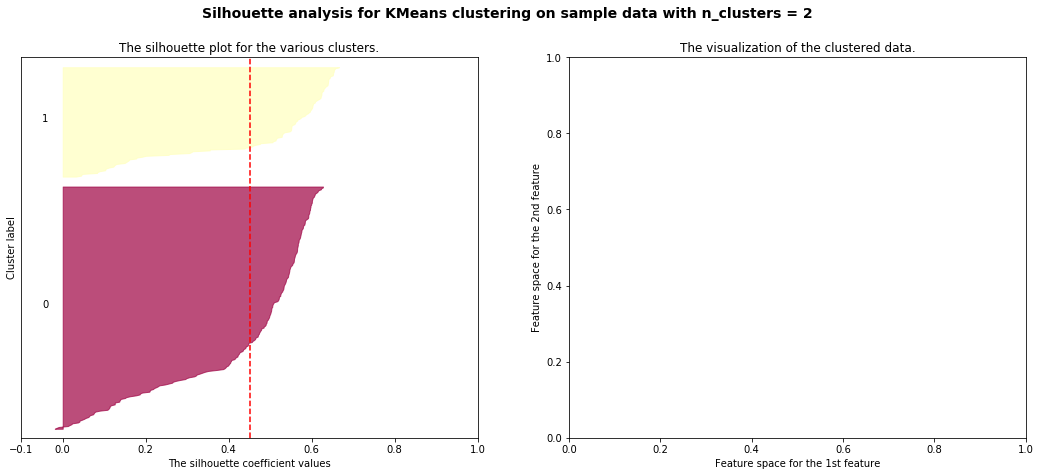

For n_clusters = 3 The average silhouette_score is : 0.35088461912738933


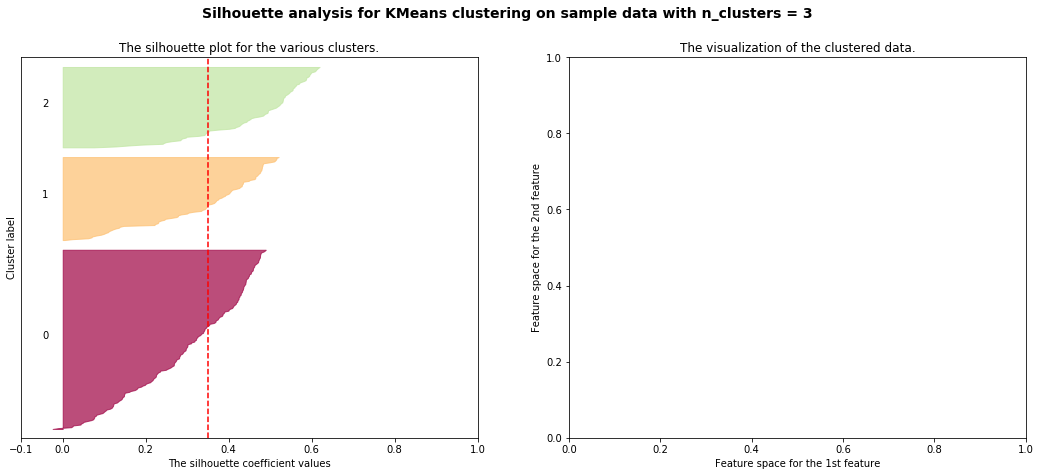

For n_clusters = 4 The average silhouette_score is : 0.3458551298068436


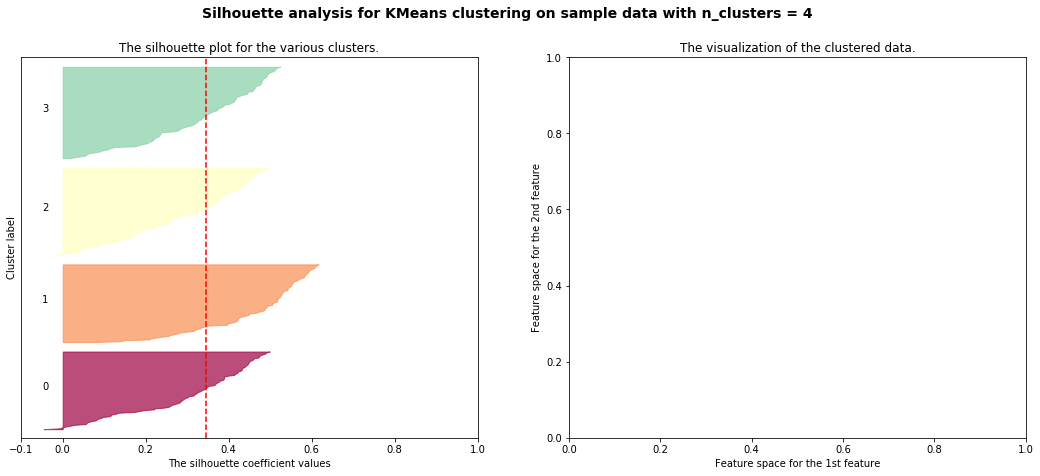

For n_clusters = 5 The average silhouette_score is : 0.31439814026213353


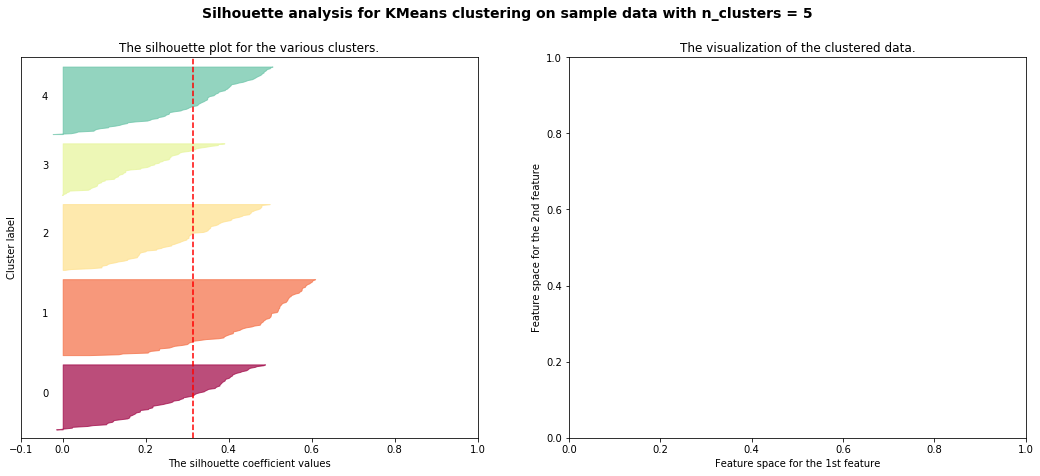

In [687]:
#Measure the accuracy of KMeans Algorithm through the plotting of SilScore
range_n_clusters = [2, 3, 4, 5]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(cars_df) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(cars_df)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(cars_df, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(cars_df, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        cmap = cm.get_cmap("Spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cmap(cluster_labels.astype(float) / n_clusters)
   # ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
      #          c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    #ax2.scatter(centers[:, 0], centers[:, 1],
     #           marker='o', c="white", alpha=1, s=200)

    #for i, c in enumerate(centers):
     #   ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

    plt.show()


###### Observation of SilScore:
    Optimal Clustering will be: High Average SilScore and all clusters cross Average SilScore
    For above plotting as well: 
                       It looks like Average SilScore is high for 3 clusters and all clusters 
                       cross Average SilScore

Point 3.b: Using Agglomerative Clustering to find the clusters

In [688]:
model = AgglomerativeClustering(affinity='euclidean',  linkage='average')

In [689]:
model.fit(cars_df)

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=None, linkage='average', memory=None,
            n_clusters=2, pooling_func='deprecated')

In [690]:
agglomerative_labels=model.labels_

In [691]:
agglomerative_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [692]:
#Measuring how accurate Agglomerative Clustering is
Z = linkage(cars_df, 'average')
c, coph_dists = cophenet(Z , pdist(cars_df))

In [693]:
c

0.7842309041847632

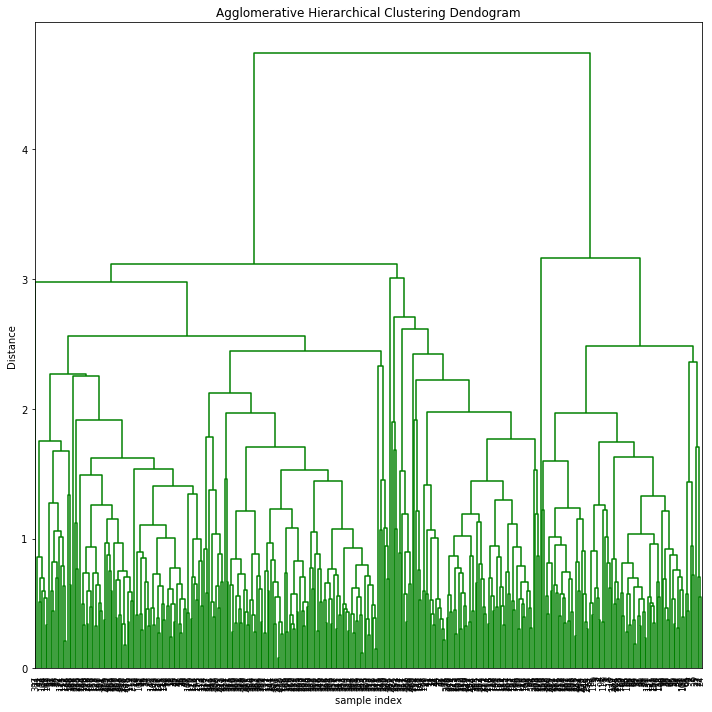

In [694]:
# Agglomerative Clustering Dendogram
plt.figure(figsize=(10, 10))
plt.title('Agglomerative Hierarchical Clustering Dendogram')
plt.xlabel('sample index')
plt.ylabel('Distance')
dendrogram(Z, leaf_rotation=90.,color_threshold = 30, leaf_font_size=8. )
plt.tight_layout()

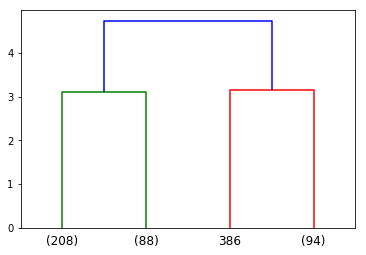

In [724]:
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=4,  # show only the last p merged clusters
)
plt.show()

In [695]:
#Finally assigning each observation to its cluster wherein clusters are identified using KMeans
cars_df["cluster_id"]=KMeans_labels
cars_df

,cyl,disp,wt,acc,yr,mpg,hp,cluster_id
0,1.483947,1.077290,0.664133,0.620540,-1.285258,-1.625315,-0.698638,1
1,1.483947,1.488732,1.574594,0.843334,-1.466724,-1.625315,-1.083498,1
2,1.483947,1.182542,1.184397,0.540382,-1.648189,-1.625315,-0.698638,1
3,1.483947,1.048584,1.184397,0.536845,-1.285258,-1.625315,-0.955212,1
4,1.483947,1.029447,0.924265,0.555706,-1.829655,-1.625315,-0.826925,1
5,1.483947,2.244637,2.433030,1.607198,-2.011120,-1.625315,-1.083498,1
7,1.483947,2.349890,2.875254,1.573013,-2.555517,-1.625315,-1.211785,1
9,1.483947,1.871469,2.224924,1.028406,-2.555517,-1.625315,-1.083498,1
10,1.483947,1.804490,1.704660,0.690090,-2.011120,-1.625315,-1.083498,1
11,1.483947,1.393047,1.444529,0.744315,-2.736983,-1.625315,-1.211785,1


###### Point 5: Using Regression Model separately on different clusters and printing the coefficients

In [696]:
features=["acc","cyl","disp","wt","yr","hp"]
target=["mpg"]

<Figure size 216x216 with 0 Axes>

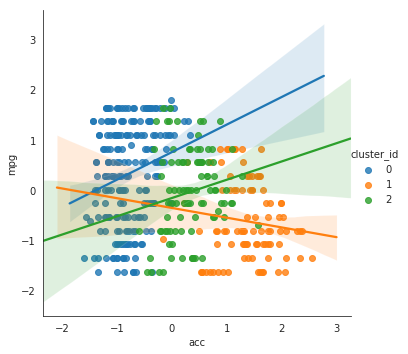

<Figure size 216x216 with 0 Axes>

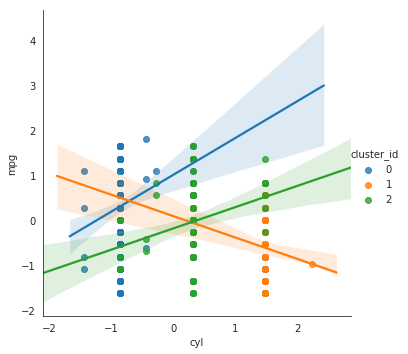

<Figure size 216x216 with 0 Axes>

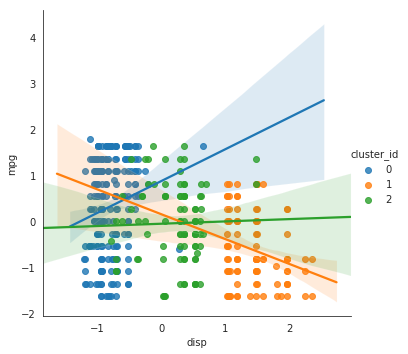

<Figure size 216x216 with 0 Axes>

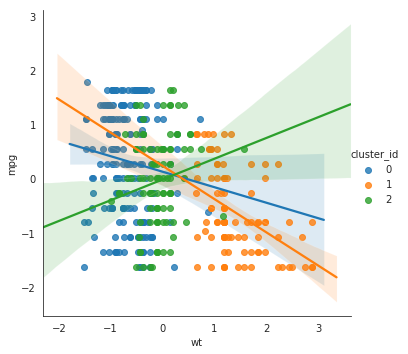

<Figure size 216x216 with 0 Axes>

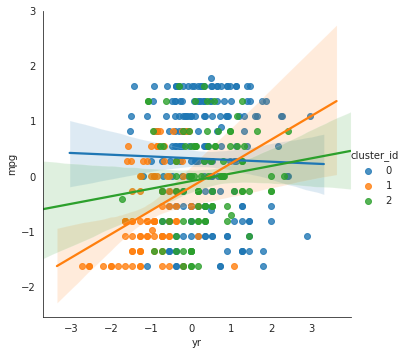

<Figure size 216x216 with 0 Axes>

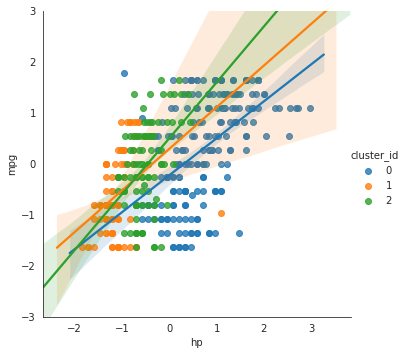

In [697]:
for col in features:
    with sns.axes_style("white"):
        plt.figure(figsize=(3,3))
        plot = sns.lmplot(col,'mpg',data=cars_df,hue='cluster_id')
plot.set(ylim = (-3,3))

In [698]:
cars_df.groupby("cluster_id").count()

,cyl,disp,wt,acc,yr,mpg,hp
cluster_id,,,,,,,
0,204,204,204,204,204,204,204
1,92,92,92,92,92,92,92
2,95,95,95,95,95,95,95


In [699]:
cluster0_records=cars_df[cars_df["cluster_id"]==0]
cluster1_records=cars_df[cars_df["cluster_id"]==1]
cluster2_records=cars_df[cars_df["cluster_id"]==2]

In [700]:
regression=LinearRegression()

###### Fitting the Linear Regression for First Cluster

In [701]:
X_0=cluster0_records[features]
y_0=cluster0_records[target]

In [702]:
X_train,X_test,y_train,y_test=train_test_split(X_0,y_0,test_size=0.20)

In [703]:
cluster0_model=regression.fit(X_train,y_train)

In [704]:
cluster0_model.intercept_

array([0.37669913])

In [705]:
cluster0_model.coef_

array([[ 1.41477619, -0.42201801,  0.45791099, -0.66874086, -0.22919523,
         0.93805966]])

In [706]:
y_predict=regression.predict(X_test)

In [707]:
score=r2_score(y_test,y_predict)
print(score)

0.5007423149719736


###### Fitting the Linear Regression for Second Cluster

In [708]:
X_1=cluster1_records[features]
y_1=cluster1_records[target]

In [709]:
X_train,X_test,y_train,y_test=train_test_split(X_1,y_1,test_size=0.20)

In [710]:
cluster1_model=regression.fit(X_train,y_train)

In [711]:
cluster1_model.intercept_

array([10.29746048])

In [712]:
cluster1_model.coef_

array([[-0.33272956, -6.28255548,  1.22846226, -0.33282761,  0.75550925,
         1.41210825]])

In [713]:
y_predict=regression.predict(X_test)

In [722]:
score=r2_score(y_test,y_predict)
score

0.26439125478285275

###### Fitting the Linear Regression for Third Cluster

In [715]:
X_2=cluster2_records[features]
y_2=cluster2_records[target]

In [716]:
X_train,X_test,y_train,y_test=train_test_split(X_2,y_2,test_size=0.20)

In [717]:
cluster2_model=regression.fit(X_train,y_train)

In [718]:
cluster2_model.intercept_
        

array([0.20613683])

In [719]:
cluster2_model.coef_

array([[ 0.71313758,  0.66288309, -0.73845004,  0.30277562,  0.21123703,
         1.16842645]])

In [720]:
y_predict=regression.predict(X_test)

In [721]:
score=r2_score(y_test,y_predict)
score

0.26439125478285275

# Problems:
    

I am not able to determine when a single regression model should be used for all clusters and
when different Linear Models should be used for different cluster?
    
If we consider current situation:
   
     From the above lmplot, i can assume, three models to be built because single linear model
     will not accomodate data for every cluster efficiently

But when Three Linear Equations are built, R2 Score for each Model is so low. Why?
    
  